goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [2]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

from math import floor

import sys

In [3]:
# experimental parameters for model training, for simple configuration in a single cell.
# very useful for reporting spreadsheet

folder_key = {}

split_interval_secs = 2.5
split_length = 10000000000000 # absurd number for future use
sample_rate = 32000

total_folders = 50
min_rating = 5.0
max_files_per_folder = 20

sampling_technique = "median"

test_size = 0.2

epochs = 500
batch_size = 1024
dropout_rate = 0
learning_rate = 0.001
momentum = 0
experimental = False
save_best_to_file = False

In [4]:
def reset_seed():
    torch.manual_seed(1368)
    random.seed(1368)
    np.random.seed(1368)

reset_seed()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).total_memory)

print(device)
print(torch.cuda.get_device_name())

8546353152
cuda
NVIDIA GeForce RTX 5060


In [6]:
def get_random_folders_filtered(base_dir: str, split_interval_secs: float, sample_rate: int = 32000, total_folders: int = 50, max_files_per_folder: int = -1, min_rating: float = 4.0):
    global split_length, folder_key
    # base_dir: directory of all the audio file folders
    # split_interval_secs: the length of each sound clip when split up in a file.
    #   - final dataframe will not contain any sound clips over/under this length
    # sample_rate: sample rate of sound clips in hz
    # total_folders: total folders to iterate through the files, given range of files per folder
    # min_files_per_folder: minimum files to exist in the folder
    # max_files_per_folder: maximum files to use inside the folder

    # get the list of valid folders and files to analyse
    folder_key = {}

    folders = []
    valid_folders = set()
    valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
    for f in valid_files: valid_folders.add(f.split("/")[0])
    for folder in [line.replace("\n", "") for line in open("folder_order.txt").readlines()]:
        if folder in valid_folders:
            folders.append(folder)

    folder_count = 0

    # if there are less folders than those specified, view all folders instead of given amount
    total_folders = min(len(folders), total_folders)

    rows = []
    
    for folder in folders:
        folder_path = base_dir + folder + "/"
        valid_folder_files = []
        # only iterate through the valid audio files
        for file in os.listdir(folder_path):
            if folder + "/" + file in valid_files:
                valid_folder_files.append(folder_path + file)
        random.shuffle(valid_folder_files)

        if max_files_per_folder > 0:
            valid_folder_files = valid_folder_files[:min(max_files_per_folder, len(valid_folder_files))]

        # iterate through each file in the folder
        for file_path in (progress_bar := tqdm(valid_folder_files)):
            # load file data and resample to sample_rate if necessary
            file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
            if file_sample_rate_hz != sample_rate:
                file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

            # convert all audio into mono (1 channel) if audio is stereo (2 channels)
            if file_data.shape[0] == 2:
                file_data = file_data.mean(dim=0)
            else:
                file_data = file_data.flatten()

            # get total number of X second splits
            total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
            
            # convert file data into mel-spectrogram fourier transform for feeding into CNN
            n_fft = 1024

            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
            amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
            mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))
            
            # if file is at least X seconds.
            if total_splits >= 1:
                split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
                mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
                for i in range(len(mel_spec_splits) - 1):
                    start = mel_spec_splits[i]
                    end = mel_spec_splits[i + 1]

                    mel_spec_split = mel_spec_data_db[:, start:end]

                    row = {}
                    row["folder"] = folder
                    row["file"] = file_path.split("/")[-1]
                    row["mel_spec"] = mel_spec_split
                    row["mel_spec_shape"] = mel_spec_split.shape

                    rows.append(row)

                folder_key[folder_count] = folder

            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")

        # end loop if total_folders has been reached
        folder_count += 1
        if folder_count >= total_folders: break

    # trim the ends of some mel spectrograms because of stupid floating point nonsense
    for row in rows:
        if row["mel_spec_shape"][1] != split_length:
            row["mel_spec"] = row["mel_spec"][:, :split_length]
            row["mel_spec_shape"] = row["mel_spec"].shape

    return pd.DataFrame(rows)

In [7]:
# base_dir = "/mnt/lustre/peprmint/train_audio/"
base_dir = "../../datasets/birdsongs-combined/train_audio/"

reset_seed()

folder_df = get_random_folders_filtered(
    base_dir, 
    split_interval_secs=split_interval_secs, 
    sample_rate=sample_rate,
    total_folders=total_folders,
    min_rating=min_rating,
    max_files_per_folder=max_files_per_folder
)

Folder 1/50 - dowwoo:   0%|          | 0/20 [00:00<?, ?it/s]

Folder 50/50 - grycat: 100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


In [8]:
folder_df["mel_spec_shape"].value_counts()

mel_spec_shape
(128, 156)    17433
Name: count, dtype: int64

In [9]:
folder_df["folder"].value_counts()

folder
banswa     1344
logshr      724
yehbla      663
scbwre1     620
grycat      565
combul2     522
brncre      516
bkskit1     499
compau      477
indbun      470
sheowl      469
verdin      455
cubthr      443
pirfly1     418
comyel      407
mitpar      392
spotow      380
buwwar      369
mawthr1     352
phaino      351
redcro      348
brnjay      348
whbman1     328
annhum      326
dowwoo      313
cobtan1     312
bkbmag1     305
peflov      299
eucdov      296
yehcar1     288
royter1     285
barswa      268
combuz1     265
whiwre1     258
blhpar1     255
amtspa      221
piebus1     216
leater1     203
ocbfly1     203
rerswa1     197
comloo      192
yebsap      191
oliwoo1     178
lotduc      172
insowl1     171
blkfra      143
zebdov      137
amepip      115
brubru1      93
litegr       71
Name: count, dtype: int64

In [10]:
print("sound clips BEFORE any sampling:", len(folder_df))

sound clips BEFORE any sampling: 17433


In [11]:
len(folder_df["folder"].unique())

50

<Axes: title={'center': 'Value counts before over/under sampling.'}, xlabel='folder'>

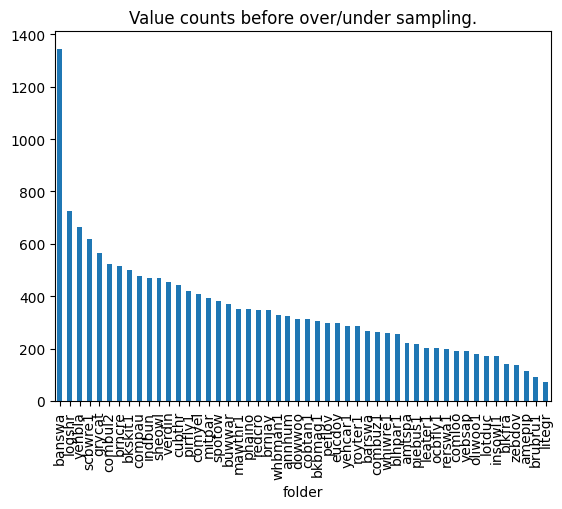

In [12]:
folder_df["folder"].value_counts().plot.bar(title="Value counts before over/under sampling.")

In [13]:
# apply random undersampling OR oversampling

reset_seed()

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

if sampling_technique == "median":
    # take the median value of folder counts
    # under sample all above the median
    # over smaple all below the median

    ros = RandomOverSampler(random_state=1368)
    median_folder_count = round(folder_df["folder"].value_counts().median())
    indices_to_keep = np.array([])

    print("median:", median_folder_count)

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        if folder_length > median_folder_count:
            indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=median_folder_count), indices_to_keep])
        else:
            indices_to_keep = np.concat([folder_df[folder_df["folder"] == f].index, indices_to_keep])
        
    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)
    
    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)

median: 312


<Axes: title={'center': 'Value counts after median sampling.'}, xlabel='folder'>

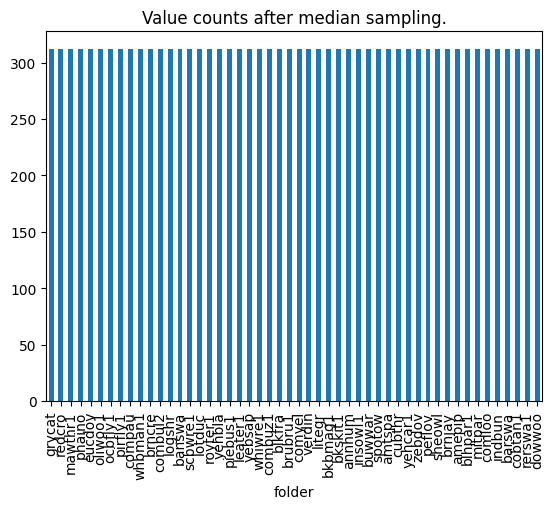

In [14]:
folder_df["folder"].value_counts().plot.bar(title=f"Value counts after {sampling_technique} sampling.")

In [15]:
print("sound clips AFTER sampling:", len(folder_df))

sound clips AFTER sampling: 15600


torch.Size([128, 156])


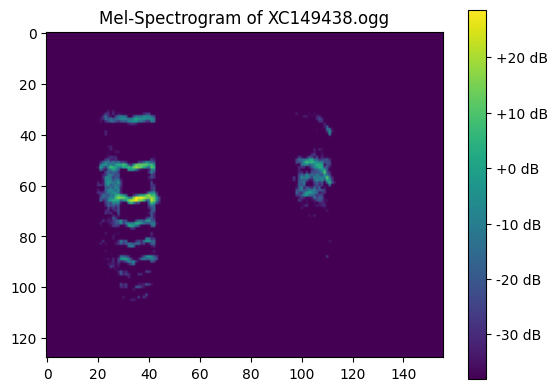

torch.Size([128, 156])


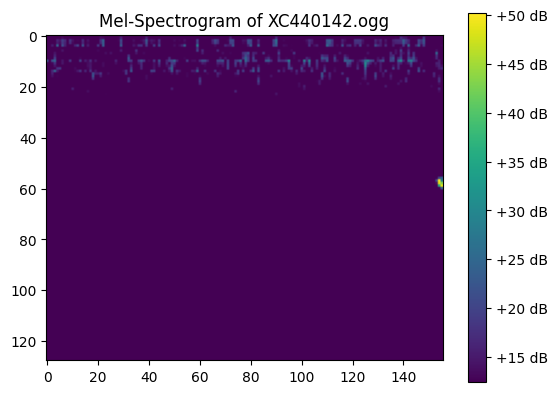

torch.Size([128, 156])


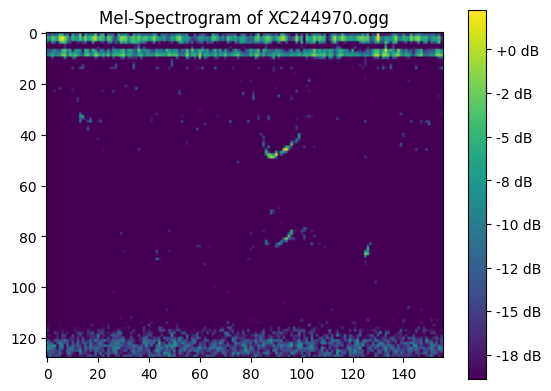

In [16]:
# plot 5 random mel spectrograms
# checks for consistency in scaling and whatnot

reset_seed()

sample_spec_indices = random.sample(folder_df.index.tolist(), k=3)

for i in sample_spec_indices:
    row = folder_df.iloc[i]
    
    print(row["mel_spec_shape"])
    
    plt.figure()
    plt.imshow(row["mel_spec"])
    plt.title(f"Mel-Spectrogram of {'/'.join(row['file'].split('/')[-2:])}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

del row

In [17]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)

x = torch.from_numpy(np.stack(folder_df["mel_spec"].values))
x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
x = x.to(device)

le = LabelEncoder()
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
y = y.to(device)

In [18]:
reset_seed()

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=test_size, random_state=1368)

del x, y

In [19]:
# create machine learning model.

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")

        # define layers here
        # assuming input shape = 1x1x128x126 = AxBxCxD

        # conv2d: 1x128x126 -> 1x124x124 (kernel size = (5,3))
        # relu
        # max pool: 1x124x124 -> 1x62x62 (pool size = (2,2))
        # conv2d: 1x62x62 -> 1x60x60 (kernel size = (3, 3))
        # relu
        # max pool: 1x60x60 -> 1x30x30 (pool size = (2, 2))
        # flatten: 1x30x30 -> 900
        # linear: 900 -> 128
        # linear: 128 -> 32
        # linear: 32 -> (output layers)

        A = input_shape[0]
        B = input_shape[1]
        C = input_shape[2]
        D = input_shape[3]

        self.conv1 = nn.Conv2d(in_channels=B, out_channels=1, kernel_size=(5, 3)) # output shape = Ax1x(C-4)x(D-2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # output shape = Ax1x(C-4 // 2)x(D-2 // 2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3)) # output shape = Ax1x(C - 4 // 2 - 2)x(D - 2 // 2 - 2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) # output shape = Ax1x([(C - 4) // 2 - 2] // 2)x([(D - 2) // 2] - 2] // 2) idk the bracket order
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()

        flatten_nodes = ((((C - 4) // 2) - 2) // 2) * ((((D - 2) // 2) - 2) // 2)
        
        self.linear1 = nn.Linear(in_features=flatten_nodes, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=32) 
        self.output = nn.Linear(in_features=32, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output(x)

        return x

In [20]:
# model: the model to train
# loss_fn: the loss function to update weights
# optimizer: the optimiser function to affect rate of change
# epochs: number of epochs to train the model over
# batch_size: samples to train x_train and y_train to avoid memory issues
# save_best_to_file: save model with highest test accuracy to models/ folder.
# experimental: whether to end training after 5 consecutive runs of no higher test accuracy.
#       - training ends when either [epochs] epochs have been run, *OR* if 5 consecutive runs do not improve test accuracy from previous best.

def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False, experimental = False):
    global x_train, y_train
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    experimental_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            x_batch, y_batch = shuffle(x_batch, y_batch)

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if experimental:
            experimental_counter += 1

        if test_acc > best_test_acc:
            experimental_counter = 0
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

        if experimental_counter == 5:
            print("Experimental Mode ended the training early, as the testing accuracy had not increased over 5 consecutive epochs.")
            break
        
    if save_best_to_file:
        model_save_path = "models/"
        if not os.path.exists(model_save_path): os.mkdir(model_save_path)
        file_number = len(os.listdir(model_save_path)) + 1
        file_name = f"best_model_{file_number:>03}"
        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} sound clips over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

Epoch 1: train loss = 3.6472, train acc = 7.15%, test acc = 10.35% !!
Epoch 2: train loss = 3.3343, train acc = 12.99%, test acc = 15.61% !!
Epoch 3: train loss = 3.0703, train acc = 20.37%, test acc = 20.29% !!
Epoch 4: train loss = 2.8761, train acc = 26.20%, test acc = 23.81% !!
Epoch 5: train loss = 2.6847, train acc = 31.76%, test acc = 26.19% !!
Epoch 6: train loss = 2.5232, train acc = 36.15%, test acc = 30.10% !!
Epoch 7: train loss = 2.3835, train acc = 40.07%, test acc = 31.89% !!
Epoch 8: train loss = 2.2627, train acc = 43.53%, test acc = 33.72% !!
Epoch 9: train loss = 2.1595, train acc = 46.63%, test acc = 34.55% !!
Epoch 10: train loss = 2.0699, train acc = 48.90%, test acc = 36.09% !!
Epoch 11: train loss = 1.9928, train acc = 51.15%, test acc = 36.83% !!
Epoch 12: train loss = 1.9239, train acc = 53.44%, test acc = 37.50% !!
Epoch 13: train loss = 1.8633, train acc = 55.49%, test acc = 38.37% !!
Epoch 14: train loss = 1.8082, train acc = 57.12%, test acc = 38.94% !!
Ep

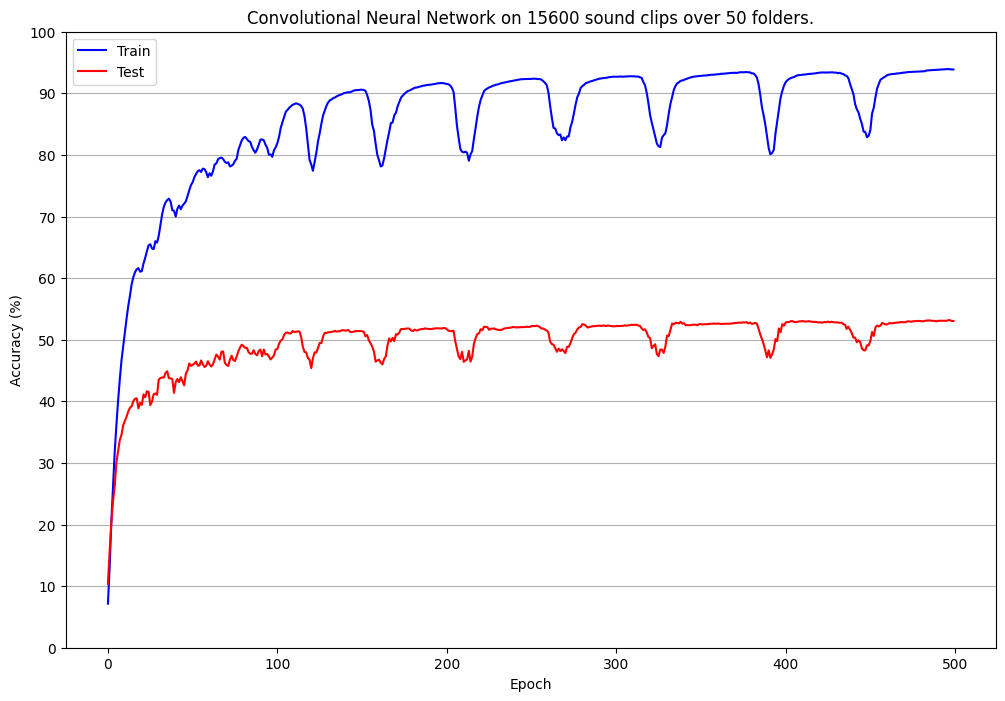

In [21]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

reset_seed()

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=save_best_to_file, experimental=experimental)

In [22]:
# final results after testing approx. 30 different variations of dropout, learning rate, etc
# best learning rate = 0.001, batch size of 32/64, dropout rate around 0.2-0.5
# 200 epochs gives best results as test acc plateaus after that, prevents overfitting
# train/test split between 20-30% gives good results

In [23]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Accuracy: {top_k_accuracy:.03f}%")

Top 5 Accuracy: 69.103%


In [24]:
folder_df["file"].value_counts()

file
XC416747.mp3    144
XC350953.ogg    122
XC319994.ogg    118
XC352051.ogg    100
XC552106.ogg    100
               ... 
XC650878.ogg      1
XC591468.ogg      1
XC610231.ogg      1
XC367704.ogg      1
XC348944.mp3      1
Name: count, Length: 856, dtype: int64

In [25]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
48,24,61,39.34
45,24,52,46.15
39,30,63,47.62
33,33,65,50.77
15,38,74,51.35
40,36,69,52.17
43,28,52,53.85
5,32,58,55.17
27,28,47,59.57
38,40,66,60.61


In [200]:
# takes in a whole file as input, feeds into the model, performs sequential aggregation
# gives a single output based on aggregation strategy
def test_file(folder, file_path):
    global sample_rate, split_length, model
    samples = []
    
    # load file data and resample to sample_rate if necessary
    file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
    if file_sample_rate_hz != sample_rate:
        file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

    # convert all audio into mono (1 channel) if audio is stereo (2 channels)
    if file_data.shape[0] == 2: file_data = file_data.mean(dim=0)
    else: file_data = file_data.flatten()

    # get total number of X second splits
    total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
    
    # convert file data into mel-spectrogram fourier transform for feeding into CNN
    n_fft = 1024

    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
    amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
    mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))
    
    # if file is at least X seconds.
    if total_splits >= 1:
        split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
        mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
        for i in range(len(mel_spec_splits) - 1):
            start = mel_spec_splits[i]
            end = mel_spec_splits[i + 1]

            mel_spec_split = mel_spec_data_db[:, start:end]

            # add testing sample to end
            samples.append(mel_spec_split.reshape(1, 128, -1).numpy())
    else:
        return None

    samples = torch.Tensor(np.array(samples)).to(device)

    preds = model(samples)

    # Ax[classes] sized array, A = number of splits in file

    # sequential aggregation via summation
    seq_aggregation_result = torch.sum(preds, dim=0)

    prediction_order = [folder_key[i] for i in torch.topk(seq_aggregation_result, k=len(seq_aggregation_result)).indices.cpu().numpy()]
    location = prediction_order.index(folder) + 1 # because of zero index, adjust to make it 1-indexed

    return location, prediction_order

In [201]:
random_folder = "../../datasets/birdsongs-combined/train_audio/" + random.choice([i for i in folder_key.values()]) + "/"
random_file = random_folder + random.choice(os.listdir(random_folder))

print(random_file)

test_file(random_folder.split("/")[-2], random_file)

../../datasets/birdsongs-combined/train_audio/lotduc/XC203476.ogg


(42,
 ['whiwre1',
  'mawthr1',
  'spotow',
  'amtspa',
  'phaino',
  'eucdov',
  'amepip',
  'oliwoo1',
  'redcro',
  'grycat',
  'buwwar',
  'blhpar1',
  'comloo',
  'bkskit1',
  'yebsap',
  'piebus1',
  'leater1',
  'yehbla',
  'comyel',
  'compau',
  'litegr',
  'yehcar1',
  'mitpar',
  'brncre',
  'bkbmag1',
  'sheowl',
  'blkfra',
  'combul2',
  'logshr',
  'cubthr',
  'brnjay',
  'cobtan1',
  'peflov',
  'barswa',
  'scbwre1',
  'annhum',
  'combuz1',
  'whbman1',
  'ocbfly1',
  'indbun',
  'royter1',
  'lotduc',
  'dowwoo',
  'banswa',
  'verdin',
  'rerswa1',
  'brubru1',
  'pirfly1',
  'zebdov',
  'insowl1'])

In [209]:
# do above but for EVERY SINGLE FILE in the classes used

base_path = "../../datasets/birdsongs-combined/train_audio/"

sequential_aggregation_results = {}

for folder in (progress_bar := tqdm(folder_key.values())):

    folder_path = base_path + folder + "/"

    folder_length = len(os.listdir(folder_path))
    file_counter = 0
    for file in os.listdir(folder_path):
        file_counter += 1
        progress_bar.set_description(f"{folder} - {file_counter}/{folder_length}")
        
        file_path = folder_path + file

        result = test_file(folder, file_path)
        if result:
            sequential_aggregation_results[folder] = sequential_aggregation_results.get(folder, []) + [result[0]]


grycat - 301/301: 100%|██████████| 50/50 [11:07<00:00, 13.35s/it] 


In [220]:
rows = []

for folder in sequential_aggregation_results.keys():
    row = {}

    results = sequential_aggregation_results[folder]

    row["folder"] = folder
    row["total_files"] = len(results)
    row["in_top_1_percentage"] = round(sum([1 if result == 1 else 0 for result in results]) * 100 / len(results), 2)
    row["in_top_5_percentage"] = round(sum([1 if result <= 5 else 0 for result in results]) * 100 / len(results), 2)

    rows.append(row)

sequential_aggregation_df = pd.DataFrame(rows)
sequential_aggregation_df.sort_values(by="in_top_5_percentage", ascending=False)

,folder,total_files,in_top_1_percentage,in_top_5_percentage
7,blhpar1,159,30.19,50.31
4,indbun,207,18.84,49.28
3,barswa,903,11.18,47.51
2,cobtan1,184,5.43,43.48
23,verdin,144,4.86,41.67
14,cubthr,500,11.80,31.40
28,whiwre1,148,6.76,29.05
20,bkskit1,266,4.14,28.20
37,logshr,158,6.33,24.05
13,yehcar1,126,4.76,23.81
